# TP SD-TSIA211
##### Lécluse Simon & Marcheville Gaël

In [1]:
import tp_reglog_utils as utils
import scipy
import numpy as np
import matplotlib.pyplot as plt

## 3. Tikhonov regularization

### Question 3.1

The partial derivative of $f_1$ with respect to $w_0$ is :

$$\frac{\partial f_1}{\partial w_0} = \frac{1}{n} \sum_{i=1}^{n} -\frac{y_i}{1+\exp(y_i(x_i^Tw+w_0))}$$

The partial derivative of $f_1$ with respect to $w_i$ is :

$$\frac{\partial f_1}{\partial w_i} = \frac{1}{n} \sum_{i=1}^{n} -\frac{y_i x_i . e_i}{1+\exp(y_i(x_i^Tw+w_0))} + \rho w_i$$

Therefore the gradient of $f_1$ is :

$$\nabla f_1(\tilde{w}) = \frac{1}{n} \sum_{i=1}^{n} -\frac{y_i \tilde{x_i}}{1+\exp(y_i\tilde{x_i}^T \tilde{w})} + \rho w $$

with $\tilde w = (w_0, w) = (w_0, w_1, ..., w_p)$  and  $ \tilde x_i = (1, x_{i, 1}, ... x_{i, p}) $

The hessian matrix of $f_1$ is equal to :

$$ \nabla ^2 f_1(\tilde w) = \frac {1}{n} \sum_{i=1}^{n} \frac{y_i^2 \tilde{x_i} \tilde{x_i}^T }{( 1+\exp(y_i\tilde{x_i}^T \tilde{w}) )^2} + \rho (I_{p+1} - E_{11}) $$

We can notice that the matrix is defined positive, because it is a sum of such matrices. Indeed, $x_i x_i^T$ has positive eigen values $\forall x_i$, and $I_{p+1}$ has also positive eigen values. Hence $f_1$ is convex.

### Question 3.2

In [2]:
def f1(wt):
    rho = 1/n
    val = 0
    for i in range(n):
        val += np.log(1 + np.exp(-y[i] * np.dot(Xt[i], wt)))
    val = val/n + rho/2 * np.dot(wt[1:].T, wt[1:])
    return val

def grad_f1(wt):
    rho = 1/n
    grad = 0
    for i in range(n):
        grad -= y[i] * Xt[i].T / (1 + np.exp(y[i] * np.dot(Xt[i], wt)))
    grad = grad/n + rho * wt
    return grad

def hess_f1(wt):
    rho = 1/n
    I = np.eye(len(wt))
    I[0, 0] = 0
    hess = np.zeros((len(wt), len(wt)))
    for i in range(n):
        hess += y[i]**2 * np.exp(y[i] *Xt[i] @ wt) / (1 + np.exp(y[i] *Xt[i] @ wt))**2 * np.outer(Xt[i].T, Xt[i])
    hess /= n
    hess += rho * I
    return hess


In [3]:
data = utils.load_data("tfidf_matrix_97MB.npz", "feature_names_97MB.npy")

Xt = data[0]
y = data[1]
n = len(y)


In [4]:
scipy.optimize.check_grad(f1, grad_f1, np.ones((Xt.shape[1], )))


0.00012892831083053785

The error is about $10^{-4}$, this validate our calculations for the gradient and the hessian matrix of $f_1$.

In [5]:
hess_f1(np.zeros((Xt.shape[1], )))

array([[0.25      , 0.05359961, 0.05074763, ..., 0.06745536, 0.14326925,
        0.096354  ],
       [0.05359961, 0.26159167, 0.02377477, ..., 0.01879477, 0.03259928,
        0.02012643],
       [0.05074763, 0.02377477, 0.26040129, ..., 0.01196662, 0.02506709,
        0.02313315],
       ...,
       [0.06745536, 0.01879477, 0.01196662, ..., 0.2683009 , 0.0423312 ,
        0.02748576],
       [0.14326925, 0.03259928, 0.02506709, ..., 0.0423312 , 0.33220431,
        0.06168203],
       [0.096354  , 0.02012643, 0.02313315, ..., 0.02748576, 0.06168203,
        0.28723638]])

### Question 3.3

In [13]:
def line_search(xk, grad, hess, step):
    hess_inv = np.linalg.inv(hess)
    fxk = f1(xk)
    gamma_k = 1
    x_plus = xk - gamma_k * hess_inv @ grad
    cond = fxk + grad @ (x_plus-xk) + 1/(2*gamma_k) * (x_plus-xk).T @ hess @ (x_plus-xk)
    i = 0
    while f1(x_plus) > cond :
        i += 1
        gamma_k *= step
        x_plus = xk - gamma_k * hess_inv @ grad
        cond = fxk + grad @ (x_plus-xk) + 1/(2*gamma_k) * (x_plus-xk).T @ hess @ (x_plus-xk)
        #print(f"line search ; step {i} ; cond = {cond} ; val = {f1(xk)}")
    return gamma_k    

def armijo(xk, grad, hess, a, b):
    l = 0
    hess_inv = np.linalg.inv(hess)
    fxk = f1(xk)
    gamma_k = b*a**l
    x_plus = xk - gamma_k * hess_inv @ grad
    cond = fxk - gamma_k * grad @ (x_plus-xk) + gamma_k/2 * (x_plus-xk).T @ hess @ (x_plus-xk)
    while f1(x_plus) > cond:
        gamma_k = b*a**l
        l += 1
        x_plus = xk - gamma_k * hess_inv @ grad
        cond = fxk - gamma_k * grad @ (x_plus-xk) + gamma_k/2 * (x_plus-xk).T @ hess @ (x_plus-xk)
        print(f"---- armijo search ; step {l} ; cond = {cond} ; gamma = {gamma_k}")
    return gamma_k

def newton(x0, eps=10**-4, ITER_MAX=30, print_advance=True, armijo_mod=False, step=0.7, log_plot=False):
    xk = x0
    k = 0
    gamma_k = 1
    norm = np.linalg.norm(grad_f1(xk))
    grad_norms = [norm]
    while norm>eps and k<ITER_MAX :
        k += 1
        grad = grad_f1(xk)
        hess = hess_f1(xk)
        
        if armijo_mod :
            #gamma_k = line_search(xk, grad, hess, np.linalg.inv(hess) @ grad)
            gamma_k = armijo(xk, grad, hess, 0.5, 2*gamma_k)
        else :
            gamma_k = 1
        xk = xk - gamma_k * np.linalg.inv(hess) @ grad
        
        norm = np.linalg.norm(grad)
        grad_norms.append(norm)
        if print_advance:
            print(f"step {k}, norm = {norm}, value = {f1(xk)}")
    if log_plot:
        plt.plot(list(range(k+1)), grad_norms)
        plt.yscale("log")
        plt.title("Evolution of log gradient norm")
        plt.show()
    
    return xk, grad_norms
    

step 1, norm = 1.4950280608255968, value = 0.5723696681703263
step 2, norm = 0.18966932407383372, value = 0.5681201923076636
step 3, norm = 0.017505388623825, value = 0.5680680092178594
step 4, norm = 0.00023557519739635034, value = 0.5680680162241234
step 5, norm = 5.0192511215430255e-08, value = 0.5680680158078425
step 6, norm = 4.2114304173954656e-10, value = 0.5680680158174481
step 7, norm = 9.721943723848784e-12, value = 0.568068015817228


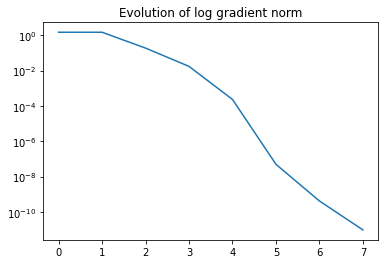

In [14]:
xk, normes = newton(x0=np.zeros((Xt.shape[1], )), 
       eps=10**-10,
       armijo_mod=False,
       log_plot=True
      )

<ipython-input-2-8973a7a9d0d4>:23: RuntimeWarning: overflow encountered in double_scalars
  hess += y[i]**2 * np.exp(y[i] *Xt[i] @ wt) / (1 + np.exp(y[i] *Xt[i] @ wt))**2 * np.outer(Xt[i].T, Xt[i])
<ipython-input-2-8973a7a9d0d4>:5: RuntimeWarning: overflow encountered in exp
  val += np.log(1 + np.exp(-y[i] * np.dot(Xt[i], wt)))
<ipython-input-2-8973a7a9d0d4>:13: RuntimeWarning: overflow encountered in exp
  grad -= y[i] * Xt[i].T / (1 + np.exp(y[i] * np.dot(Xt[i], wt)))


step 1, norm = 2.975073967202188, value = inf


<ipython-input-2-8973a7a9d0d4>:23: RuntimeWarning: overflow encountered in exp
  hess += y[i]**2 * np.exp(y[i] *Xt[i] @ wt) / (1 + np.exp(y[i] *Xt[i] @ wt))**2 * np.outer(Xt[i].T, Xt[i])
<ipython-input-2-8973a7a9d0d4>:23: RuntimeWarning: invalid value encountered in double_scalars
  hess += y[i]**2 * np.exp(y[i] *Xt[i] @ wt) / (1 + np.exp(y[i] *Xt[i] @ wt))**2 * np.outer(Xt[i].T, Xt[i])


step 2, norm = 9.15108952174807, value = nan
step 3, norm = nan, value = nan


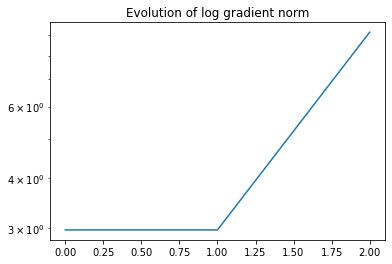

In [15]:
xk, normes = newton(x0=np.ones((Xt.shape[1], )), 
       eps=10**-4,
       armijo_mod=False,
       log_plot=True
      )

The norm of the gradient is almost constant using Newton's method without linear search, for the initial point (1, ..., 1). Hence it seems that the algorithm won't converge to a minimum.

This might be because this algorithm isn't optimal because we are never looking for the best step coefficient, which would considerably improve the efficiency of the algorithm.
A line search would here be the solution.

### Question 3.5

<ipython-input-2-8973a7a9d0d4>:23: RuntimeWarning: overflow encountered in double_scalars
  hess += y[i]**2 * np.exp(y[i] *Xt[i] @ wt) / (1 + np.exp(y[i] *Xt[i] @ wt))**2 * np.outer(Xt[i].T, Xt[i])
<ipython-input-2-8973a7a9d0d4>:5: RuntimeWarning: overflow encountered in exp
  val += np.log(1 + np.exp(-y[i] * np.dot(Xt[i], wt)))
<ipython-input-2-8973a7a9d0d4>:13: RuntimeWarning: overflow encountered in exp
  grad -= y[i] * Xt[i].T / (1 + np.exp(y[i] * np.dot(Xt[i], wt)))


step 1, norm = 2.975073967202188, value = inf


<ipython-input-2-8973a7a9d0d4>:23: RuntimeWarning: overflow encountered in exp
  hess += y[i]**2 * np.exp(y[i] *Xt[i] @ wt) / (1 + np.exp(y[i] *Xt[i] @ wt))**2 * np.outer(Xt[i].T, Xt[i])
<ipython-input-2-8973a7a9d0d4>:23: RuntimeWarning: invalid value encountered in double_scalars
  hess += y[i]**2 * np.exp(y[i] *Xt[i] @ wt) / (1 + np.exp(y[i] *Xt[i] @ wt))**2 * np.outer(Xt[i].T, Xt[i])


step 2, norm = 12.505542885533133, value = nan
step 3, norm = nan, value = nan


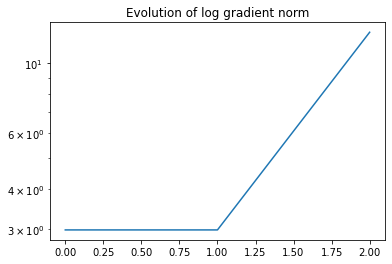

In [16]:
xk, normes = newton(x0=np.ones((Xt.shape[1], )), 
       eps=10**-4,
       ITER_MAX=50,
       armijo_mod=True,
       log_plot=True,
      )

The algorithm doesn't seem to converge to a fix point.

## 4. Regularization for a sparse model

### Question 4.1

In order to use Newton's method, the function need to be at least $\mathcal{C}^2$. Here the norm $\left\| w \right\| _1$ is not $\mathcal{C}^1$ because it is a sum of absolute values. Hence we cannot use this method here.

### Question 4.2

We can write the objective function as $F_2 = \mathcal {f_2 + g_2}$ with :

$\mathcal {f_2} = \frac{1}{n} \sum_{i=1}^{n} log(1 + exp(-y_i (x_i^T w + w_0))) \newline $
$\mathcal {g_2} = \rho \left\| w \right\| _1 \newline $

• The formula for $prox_{g_2}$ is : 

$$prox_{g_2}(x) = argmin_y (\mathcal{g_2}(y) + \frac{1}{2} \rho \left\| y-x \right\|^2 _2 ) \newline $$
$$prox_{g_2}(x) = (sign(x_i) max( \vert x_i \vert - \rho, 0))_{i \in \{1, ..., p\} }$$

• The gradient of $\mathcal {f_2}$ is : 
$$\nabla f_2(\tilde{w}) = \frac{1}{n} \sum_{i=1}^{n} -\frac{y_i \tilde{x_i}}{1+\exp(y_i\tilde{x_i}^T \tilde{w})} $$

### Question 4.3

In [10]:
def grad_f2(wt):
    grad = 0
    for i in range(n):
        grad -= y[i] * Xt[i].T / (1 + np.exp(y[i] * np.dot(Xt[i], wt)))
    grad = grad/n
    return grad

def hess_f2(wt):
    hess = np.zeros((len(wt), len(wt)))
    for i in range(n):
        hess += y[i]**2 / (1 + np.exp(y[i] *Xt[i] @ wt))**2 * np.outer(Xt[i].T, Xt[i])
    hess /= n
    return hess

def prox_g2(x, rho=0.02):
    return np.sign(x) * np.max(np.abs(x) - rho, 0)
    

In [11]:
def proximal_gradient_descent(x0, eps=10**-4, step=0.5):
    xk = x0
    k = 0
    norm = np.linalg.norm(grad_f2(xk))
    grad_norms = [norm]
    while norm > eps:
        k += 1
        grad = grad_f2(xk) ; hess = hess_f2(xk)
        gamma_k = line_search(xk, grad, hess, step)
        xk = prox_g2(xk - gamma_k * grad)
        print(f"Step = {k}, gradient norm = {norm}")
    return xk    
        

In [12]:
proximal_gradient_descent(x0=np.ones((Xt.shape[1], )),
                          eps=10**-4,
                          step=0.7)

<ipython-input-10-d1f25e96ee13>:11: RuntimeWarning: overflow encountered in double_scalars
  hess += y[i]**2 / (1 + np.exp(y[i] *Xt[i] @ wt))**2 * np.outer(Xt[i].T, Xt[i])


Step = 1, gradient norm = 2.9729563894862663
Step = 2, gradient norm = 2.9729563894862663
Step = 3, gradient norm = 2.9729563894862663
Step = 4, gradient norm = 2.9729563894862663
Step = 5, gradient norm = 2.9729563894862663
Step = 6, gradient norm = 2.9729563894862663
Step = 7, gradient norm = 2.9729563894862663
Step = 8, gradient norm = 2.9729563894862663
Step = 9, gradient norm = 2.9729563894862663
Step = 10, gradient norm = 2.9729563894862663
Step = 11, gradient norm = 2.9729563894862663
Step = 12, gradient norm = 2.9729563894862663
Step = 13, gradient norm = 2.9729563894862663
Step = 14, gradient norm = 2.9729563894862663
Step = 15, gradient norm = 2.9729563894862663
Step = 16, gradient norm = 2.9729563894862663


<ipython-input-10-d1f25e96ee13>:4: RuntimeWarning: overflow encountered in exp
  grad -= y[i] * Xt[i].T / (1 + np.exp(y[i] * np.dot(Xt[i], wt)))
<ipython-input-10-d1f25e96ee13>:11: RuntimeWarning: overflow encountered in exp
  hess += y[i]**2 / (1 + np.exp(y[i] *Xt[i] @ wt))**2 * np.outer(Xt[i].T, Xt[i])
<ipython-input-2-8973a7a9d0d4>:5: RuntimeWarning: overflow encountered in exp
  val += np.log(1 + np.exp(-y[i] * np.dot(Xt[i], wt)))


Step = 17, gradient norm = 2.9729563894862663
Step = 18, gradient norm = 2.9729563894862663
Step = 19, gradient norm = 2.9729563894862663
Step = 20, gradient norm = 2.9729563894862663
Step = 21, gradient norm = 2.9729563894862663
Step = 22, gradient norm = 2.9729563894862663
Step = 23, gradient norm = 2.9729563894862663
Step = 24, gradient norm = 2.9729563894862663
Step = 25, gradient norm = 2.9729563894862663
Step = 26, gradient norm = 2.9729563894862663
Step = 27, gradient norm = 2.9729563894862663
Step = 28, gradient norm = 2.9729563894862663
Step = 29, gradient norm = 2.9729563894862663
Step = 30, gradient norm = 2.9729563894862663
Step = 31, gradient norm = 2.9729563894862663
Step = 32, gradient norm = 2.9729563894862663
Step = 33, gradient norm = 2.9729563894862663
Step = 34, gradient norm = 2.9729563894862663
Step = 35, gradient norm = 2.9729563894862663
Step = 36, gradient norm = 2.9729563894862663
Step = 37, gradient norm = 2.9729563894862663
Step = 38, gradient norm = 2.97295

Step = 194, gradient norm = 2.9729563894862663
Step = 195, gradient norm = 2.9729563894862663
Step = 196, gradient norm = 2.9729563894862663
Step = 197, gradient norm = 2.9729563894862663
Step = 198, gradient norm = 2.9729563894862663
Step = 199, gradient norm = 2.9729563894862663
Step = 200, gradient norm = 2.9729563894862663
Step = 201, gradient norm = 2.9729563894862663
Step = 202, gradient norm = 2.9729563894862663
Step = 203, gradient norm = 2.9729563894862663
Step = 204, gradient norm = 2.9729563894862663
Step = 205, gradient norm = 2.9729563894862663
Step = 206, gradient norm = 2.9729563894862663
Step = 207, gradient norm = 2.9729563894862663
Step = 208, gradient norm = 2.9729563894862663
Step = 209, gradient norm = 2.9729563894862663
Step = 210, gradient norm = 2.9729563894862663
Step = 211, gradient norm = 2.9729563894862663
Step = 212, gradient norm = 2.9729563894862663
Step = 213, gradient norm = 2.9729563894862663
Step = 214, gradient norm = 2.9729563894862663
Step = 215, g

KeyboardInterrupt: 